# <font color='blue'>Data Science Academy - Machine Learning</font>

# <font color='blue'>Capítulo 10 - Mini-Projeto - Agrupando Clientes Por Consumo de Energia</font>

### Especificação

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

<a class="anchor" id="0.1"></a>
# Índice

1.	[Tratar os valores ausentes nos dados](#1)
2.	[Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means](#2)
3.	[Encontrar o melhor valor de K para esse conjunto de dados](#3)
4.	[Criar o modelo K-Means usando o valor de K encontrado no item 3](#4)
5.	[Criar um Meshgrid para visualização de todos os clusters](#5)
6.	[Visualizar os centróides](#6)
7.	[Calcular o Silhoutte Score](#7)
8.	[Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média)](#8)



In [17]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [18]:
# Carregando os dados
dataset = pd.read_csv('dados/household_power_consumption.txt', delimiter = ';', low_memory = False)

In [19]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [22]:
nl1,nc1=dataset.shape

In [23]:
#check the numbers of samples and features
print("O tamanho dos dados é : {} ".format(dataset.shape))


O tamanho dos dados é : (2075259, 9) 


In [24]:
col_names = [ 'Data','Hora','Potencia_ativa_global','Potencia_reativa_global','Voltagem','Intensidade_global','Sub-medicao_1','Sub-medicao_2',
             'Sub-medicao_3']
dataset.columns = col_names

dataset.columns

Index(['Data', 'Hora', 'Potencia_ativa_global', 'Potencia_reativa_global',
       'Voltagem', 'Intensidade_global', 'Sub-medicao_1', 'Sub-medicao_2',
       'Sub-medicao_3'],
      dtype='object')

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Data                       object
Hora                       object
Potencia_ativa_global      object
Potencia_reativa_global    object
Voltagem                   object
Intensidade_global         object
Sub-medicao_1              object
Sub-medicao_2              object
Sub-medicao_3              float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


#### 0. Tipos de variáveis

Nesta seção, separareos o conjunto de dados em variáveis **categóricas e numéricas**. Há uma mistura de variáveis categóricas e numéricas no conjunto de dados. Variáveis **categóricas** possuem tipo de dados **object**. Variáveis numéricas têm o tipo de dados **int64**.

In [26]:
# Encontra as variáveis categóricas

categorical = [var for var in dataset.columns if dataset[var].dtype=='O']

numerical_feats = dataset.dtypes[dataset.dtypes != "object"].index
print("Número de variáveis numéricas: ", len(numerical_feats))

categorical_feats = dataset.dtypes[dataset.dtypes == "object"].index
print("Número de variáveis categóricas: ", len(categorical_feats))

print('As variáveis categóricas são:\n\n', categorical)

Número de variáveis numéricas:  1
Número de variáveis categóricas:  8
As variáveis categóricas são:

 ['Data', 'Hora', 'Potencia_ativa_global', 'Potencia_reativa_global', 'Voltagem', 'Intensidade_global', 'Sub-medicao_1', 'Sub-medicao_2']


### 1. Tratar os valores ausentes nos dados <a class="anchor" id="1"></a>

[](#0.1)

In [27]:
dataset[categorical].isnull().sum()

Data                       0
Hora                       0
Potencia_ativa_global      0
Potencia_reativa_global    0
Voltagem                   0
Intensidade_global         0
Sub-medicao_1              0
Sub-medicao_2              0
dtype: int64

Podemos ver que não há valores ausentes nas variáveis categóricas.

In [28]:
# visualizar contagens de frequência de valores em variáveis categóricas

for var in categorical:
    print(dataset[var].value_counts())

1/10/2007     1440
26/8/2007     1440
15/12/2007    1440
14/2/2010     1440
11/3/2008     1440
              ... 
29/10/2008    1440
22/4/2010     1440
15/9/2007     1440
26/11/2010    1263
16/12/2006     396
Name: Data, Length: 1442, dtype: int64
19:51:00    1442
19:13:00    1442
19:15:00    1442
19:10:00    1442
19:32:00    1442
            ... 
06:56:00    1441
02:22:00    1441
01:34:00    1441
09:44:00    1441
07:33:00    1441
Name: Hora, Length: 1440, dtype: int64
?        25979
0.218     9565
0.216     9363
0.322     9350
0.324     9304
         ...  
9.656        1
7.264        1
8.038        1
7.956        1
8.916        1
Name: Potencia_ativa_global, Length: 4187, dtype: int64
0.000    481561
?         25979
0.100     21902
0.092     21841
0.098     21812
          ...  
1.000         1
0.950         1
1.074         1
1.240         1
1.198         1
Name: Potencia_reativa_global, Length: 533, dtype: int64
?          25979
241.180     3559
241.120     3289
241.350     3285
241.

Agora, podemos ver que existem várias variáveis como `classe de trabalho`, `ocupacao` e `pais` que contêm valores ausentes. Geralmente, os valores ausentes são codificados como `NaN` e python os detectará com o comando usual de df.isnull().sum().

Mas, neste caso, os valores ausentes são codificados como `?`. O Python falha ao detectá-los como valores ausentes, porque não os considera `?` como valores ausentes. Então, é necessároio substituir `?` com `NaN` para que o Python possa detectar esses valores ausentes.

In [29]:
dataset.replace('?', np.NaN, inplace=True)

In [30]:
def resumo(df): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    cols = ['Tipo', 'Counts', 'Distintos', 'Nulos', 'Nulos (%)', 'Uniques']
    str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques], axis = 1)

    str.columns = cols
    dtypes = str.Tipo.value_counts()
    print('___________________________\nData types:\n',str.Tipo.value_counts())
    print('___________________________')
    return str

In [31]:
details = resumo(dataset)
display(details.sort_values(by='Nulos', ascending=False))

Data shape: (2075259, 9)
___________________________
Data types:
 object     8
float64    1
Name: Tipo, dtype: int64
___________________________


,Tipo,Counts,Distintos,Nulos,Nulos (%),Uniques
Potencia_ativa_global,object,2049280,4187,25979,1.251844,"[[4.216, 5.360, 5.374, 5.388, 3.666, 3.520, 3...."
Potencia_reativa_global,object,2049280,533,25979,1.251844,"[[0.418, 0.436, 0.498, 0.502, 0.528, 0.522, 0...."
Voltagem,object,2049280,2838,25979,1.251844,"[[234.840, 233.630, 233.290, 233.740, 235.680,..."
Intensidade_global,object,2049280,222,25979,1.251844,"[[18.400, 23.000, 15.800, 15.000, 19.600, 23.2..."
Sub-medicao_1,object,2049280,89,25979,1.251844,"[[0.000, 1.000, 2.000, 6.000, 37.000, 36.000, ..."
Sub-medicao_2,object,2049280,82,25979,1.251844,"[[1.000, 2.000, 0.000, 16.000, 37.000, 36.000,..."
Sub-medicao_3,float64,2049280,33,25979,1.251844,"[[17.0, 16.0, 18.0, 9.0, 0.0, 5.0, 19.0, 10.0,..."
Data,object,2075259,1442,0,0.000000,"[[16/12/2006, 17/12/2006, 18/12/2006, 19/12/20..."
Hora,object,2075259,1440,0,0.000000,"[[17:24:00, 17:25:00, 17:26:00, 17:27:00, 17:2..."


In [32]:
convert_list=['Potencia_ativa_global', 'Potencia_reativa_global', 'Voltagem', 'Intensidade_global', 'Sub-medicao_1', 'Sub-medicao_2']
for variavel in convert_list:
    dataset[variavel] = pd.to_numeric(dataset[variavel])

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
Data                       object
Hora                       object
Potencia_ativa_global      float64
Potencia_reativa_global    float64
Voltagem                   float64
Intensidade_global         float64
Sub-medicao_1              float64
Sub-medicao_2              float64
Sub-medicao_3              float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


Observe agora que Agora as variáveis numéricas foram convertidas em de object para float64. Além disso substituimos `?` por `NaN`, e pudemos verificar que várias das nossas variáveis possuem valores ausentes os quais devem ser tratados. Parta tanto iremos remover as observações com valores ausentes.

In [34]:
dataset.dropna(inplace=True)

In [35]:
nl2,nc2=dataset.shape

In [36]:
details = resumo(dataset)
display(details.sort_values(by='Nulos', ascending=False))

Data shape: (2049280, 9)
___________________________
Data types:
 float64    7
object     2
Name: Tipo, dtype: int64
___________________________


,Tipo,Counts,Distintos,Nulos,Nulos (%),Uniques
Data,object,2049280,1433,0,0.0,"[[16/12/2006, 17/12/2006, 18/12/2006, 19/12/20..."
Hora,object,2049280,1440,0,0.0,"[[17:24:00, 17:25:00, 17:26:00, 17:27:00, 17:2..."
Potencia_ativa_global,float64,2049280,4186,0,0.0,"[[4.216, 5.36, 5.374, 5.388, 3.666000000000000..."
Potencia_reativa_global,float64,2049280,532,0,0.0,"[[0.418, 0.436, 0.498, 0.502, 0.528, 0.522, 0...."
Voltagem,float64,2049280,2837,0,0.0,"[[234.84, 233.63, 233.29, 233.74, 235.68, 235...."
Intensidade_global,float64,2049280,221,0,0.0,"[[18.4, 23.0, 15.8, 15.0, 19.6, 23.2, 22.4, 22..."
Sub-medicao_1,float64,2049280,88,0,0.0,"[[0.0, 1.0, 2.0, 6.0, 37.0, 36.0, 38.0, 25.0, ..."
Sub-medicao_2,float64,2049280,81,0,0.0,"[[1.0, 2.0, 0.0, 16.0, 37.0, 36.0, 22.0, 12.0,..."
Sub-medicao_3,float64,2049280,32,0,0.0,"[[17.0, 16.0, 18.0, 9.0, 0.0, 5.0, 19.0, 10.0,..."


In [42]:
print("O datasset, antes do préprocesamento continha {} observações e {} variáveis, o novo tamanho do datasset é : {} linhas e {} colunas. Foram removidas {} observações, ou seja {}%".format(nl1,nc1,nl2,nc2,nl1-nl2,((nl1-nl2)/nl1)*100 ))

O datasset, antes do préprocesamento continha 2075259 observações e 9 variáveis, o novo tamanho do datasset é : 2049280 linhas e 9 colunas. Foram removidas 25979 observações, ou seja 1.2518437457686005%


### 2. Coletar uma amostra de 1% dos dados para criar o modelo de clusterização com o K-Means <a class="anchor" id="2"></a>

[](#0.1)

In [43]:
dataset2=dataset.drop(['Data', 'Hora'], axis=1
#                       ,inplace=True
                     )
dataset2.head(5)

,Potencia_ativa_global,Potencia_reativa_global,Voltagem,Intensidade_global,Sub-medicao_1,Sub-medicao_2,Sub-medicao_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [44]:
# Coleta uma amostra de 1% dos dados para não comprometer a memória do computador
amostra1, amostra2 = train_test_split(dataset2, train_size = .01)

In [45]:
print("O tamanho da amostra1 é de {} e da amostra2 é de{}".format(amostra1.shape,amostra2.shape))

O tamanho da amostra1 é de (20492, 7) e da amostra2 é de(2028788, 7)


### 3. Encontrar o melhor valor de K para esse conjunto de dados <a class="anchor" id="3"></a>

[](#0.1)

Para o método de agrupamento k-means, a abordagem mais comum para responder a essa pergunta é o chamado método de elbow (cotovelo). Isso envolve executar o algoritmo várias vezes em um loop, com um número crescente de opções de cluster e, em seguida, plotar uma pontuação de cluster como uma função do número de clusters.

A pontuação é, em geral, alguma forma de distância entre clusters em relação à distância interna do cluster .

In [58]:
# Aplica redução de dimensionalidade
pca = PCA(n_components = 2).fit_transform(amostra1)

In [59]:
pca=pd.DataFrame(pca,columns=['Componente 1','Componente 2'])

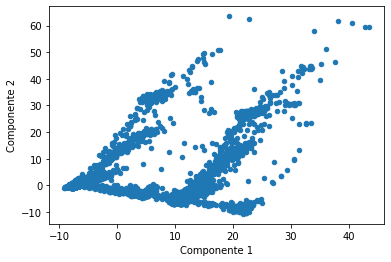

In [60]:
pca.plot(x ='Componente 1', y='Componente 2', kind = 'scatter')

In [50]:
# Determinando um range de K
k_range = range(1,12)
# Aplicando o modelo K-Means para cada valor de K
k_means_var = [KMeans(n_clusters = k).fit(pca) for k in k_range]

In [52]:
# Ajustando o centróide do cluster para cada modelo
centroids = [X.cluster_centers_ for X in k_means_var]

In [53]:
# Calculando a distância euclidiana de cada ponto de dado para o centróide
k_euclid = [cdist(pca, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis = 1) for ke in k_euclid]

In [54]:
# Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist]

In [55]:
# Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [56]:
# Soma dos quadrados entre clusters
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Valor de K')

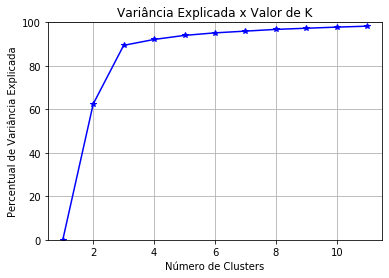

In [57]:
# Curva de Elbow
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
ax.set_ylim((0,100))
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Percentual de Variância Explicada')
plt.title('Variância Explicada x Valor de K')

### 4. Criar o modelo K-Means usando o valor de K encontrado no item 3 <a class="anchor" id="4"></a>

[](#0.1)

In [61]:
# Criando um modelo com K = 5
modelo_v1 = KMeans(n_clusters = 5)
modelo_v1.fit(pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### 5. Criar um Meshgrid para visualização de todos os clusters <a class="anchor" id="5"></a>

[](#0.1)

In [62]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca.iloc[:, 0].min() - 5, pca.iloc[:, 0].max() - 1
y_min, y_max = pca.iloc[:, 1].min() + 1, pca.iloc[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

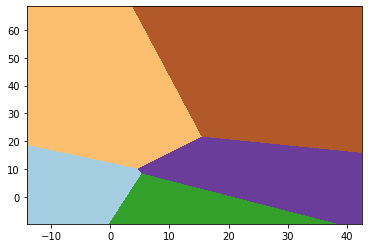

In [63]:
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')

### 6. Visualizar os centróides <a class="anchor" id="6"></a>

[](#0.1)

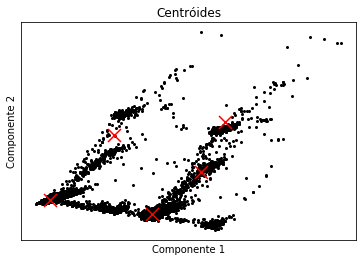

In [64]:
# Plot dos centróides
plt.plot(pca.iloc[:, 0], pca.iloc[:, 1], 'k.', markersize = 4)
centroids = modelo_v1.cluster_centers_
inert = modelo_v1.inertia_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)
plt.xticks(())
plt.yticks(())
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Centróides')
plt.show()

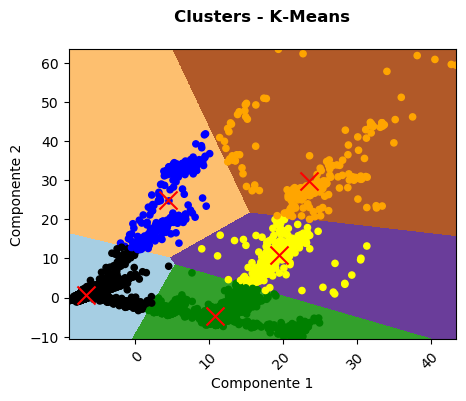

<Figure size 432x288 with 0 Axes>

In [65]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca.iloc[:, 0].min(), pca.iloc[:, 0].max()
y_min, y_max = pca.iloc[:, 1].min(), pca.iloc[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
## Plotting
fig = plt.figure(figsize=(5,4),dpi=100)
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

#Plot dos Clusters
colors = ["black", "green", "blue","yellow","orange"]
pca2=pca
pca2['cluster'] = modelo_v1.labels_
pca2['color'] = pca['cluster'].map(lambda p: colors[p])
pca2.plot(kind="scatter", x="Componente 1", y="Componente 2",c = pca2['color'],ax=ax)

#Plot dos Centroides
centroids = modelo_v1.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], marker = 'x', s = 169, linewidths = 3, color = 'r', zorder = 8)

#Plot das áreas
ax.imshow(Z, 
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Paired,
           aspect = 'auto', 
           origin = 'lower')
# Gire os rótulos dos marcadores e defina seu alinhamento. 
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

# adiciona um título e os rótulos dos eixos 
# fig.suptitle('Heatmap Correlação entre marcadores', fontsize=14, fontweight='bold')
ax.tick_params(labelsize=12)
ax.set_title('Clusters - K-Means',fontsize=12,**{'weight' : 'bold'},pad=20)
ax.set_xlabel("Componente 1",fontsize=10)
ax.set_ylabel("Componente 2",fontsize=10)

ax.tick_params(labelsize=10)

# ax.figure.subplots_adjust(left = 0.3) # change 0.3 to suit your needs
plt.show()
plt.savefig('cluster.png',dpi=300,transparent=True)

### 7. Calcular o Silhoutte Score <a class="anchor" id="7"></a>

[](#0.1)

#### silhouette_score

Calcule o coeficiente médio da silhueta de todas as amostras.

O coeficiente da silhueta é calculado usando a distância intra-cluster média (a) e a distância média do cluster mais próximo (b) para cada amostra. O coeficiente de silhueta para uma amostra é  a distância entre uma amostra e o cluster mais próximo do qual a amostra não faz parte. 
O melhor valor é 1 e o pior valor é -1. Valores próximos a 0 indicam clusters sobrepostos. Valores negativos geralmente indicam que uma amostra foi atribuída ao cluster errado, pois um cluster diferente é mais semelhante.

In [66]:
pca.drop(['cluster','color'],axis=1,inplace=True)

In [67]:
# Silhouette Score
labels = modelo_v1.labels_
silhouette_score(pca, labels, metric = 'euclidean')

0.8580226866178577

In [68]:
# Silhouette Score
# Determinando um range de K
k_range = range(2,12)
# Aplicando o modelo K-Means para cada valor de K (esta célula pode levar bastante tempo para ser executada)
k_means_Silhouette = [silhouette_score(pca, KMeans(n_clusters = k).fit(pca).labels_, metric = 'euclidean') for k in k_range]

Text(0.5, 1.0, 'Silhouette_score x Valor de K')

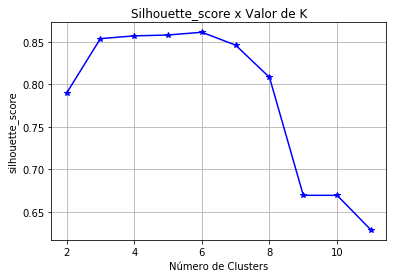

In [69]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, k_means_Silhouette, 'b*-')
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('silhouette_score')
plt.title('Silhouette_score x Valor de K')

Observe que para k=5, temos um valor de silhouette_score mais próximo de 1 (>0.85) e também apresenta um percentual de variância explicada acima de 90.

### 8. Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média) <a class="anchor" id="8"></a>

[](#0.1)

In [83]:
# Criando um modelo com K = 5
best_modelo = KMeans(n_clusters = 5)
best_modelo.fit(pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [84]:
# Cria o cluster map
cluster_map = amostra1
cluster_map['cluster'] = modelo_v1.labels_

In [85]:
cluster_map.head()

,Potencia_ativa_global,Potencia_reativa_global,Voltagem,Intensidade_global,Sub-medicao_1,Sub-medicao_2,Sub-medicao_3,cluster
1123316,1.964,0.120,243.74,8.0,0.0,0.0,0.0,0
744483,0.428,0.108,239.66,1.8,0.0,2.0,0.0,0
1138415,2.360,0.000,239.65,10.2,0.0,0.0,0.0,0
1319215,0.428,0.236,242.76,2.0,0.0,0.0,1.0,0
653594,1.462,0.058,245.57,5.8,0.0,2.0,18.0,1


In [86]:
cluster_map.groupby(['cluster'], as_index=False).mean()
# cluster_map.groupby(['cluster'], as_index=False)[['Potencia_ativa_global']].mean()

,cluster,Potencia_ativa_global,Potencia_reativa_global,Voltagem,Intensidade_global,Sub-medicao_1,Sub-medicao_2,Sub-medicao_3
0,0,0.506079,0.111812,241.624478,2.201395,0.040155,0.426977,0.412636
1,1,1.787754,0.131433,239.881089,7.456928,0.133344,0.448826,17.922357
2,2,2.874363,0.176699,238.496933,12.261333,20.592000,14.138667,0.410667
3,3,3.745076,0.207505,237.729969,15.976758,3.477064,26.125382,17.773700
4,4,4.627383,0.193753,236.198231,19.621984,34.002681,10.613941,16.048257
